# Causal Machine Learning for Treatment Effect Estimation

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR
from significance import *

import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from auxiliary_propensity_on_outcomet0_without_print import data_processing, doubly_robust, visualise, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition

from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](images\ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [2]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization. In the case of PT, 60 minutes of PT at least. 
EXPOSURE_THRESHOLD = 30#30 # SET TO 30

# set the period between observations. We only consider the effects between 120 and 240 days after exposure. 
PERIOD_MIN = 90 # /MAYBE CHECK WITH 60? 160
PERIOD_MAX = 210 # CHECK WITH 120 DAYS 380

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = True

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.6

# set to True if we want to undersample
UNDERSAMPLE = False #False #True

# set to True if we want to impute missing values
IMPUTE = True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True

TREATMENT = 'in3eb' # (minutes or days of physical therapy)
OUTCOME = 'sADLSF' 

Having set the desired parameters, we will now read in the data.

In [3]:
# file = "data/dutch_LTCF_all.csv"


import pyreadstat
# df,meta = pyreadstat.read_sav("C:/Users/Paulina.Wisniewska/Desktop/LTCF BE NL meds and icd codes 05022024.sav")
# read data
df = pd.read_csv("C:/Users/Paulina.Wisniewska/Desktop/df.csv",engine="python", encoding = 'cp1252')
print(f"Treatment before processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")


Treatment before processing 1293


## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [4]:
df= df[df['sAGE_cat']>=60]


In [5]:

clinical_contra = ['ij6c','ij6a', 'ij6b' , 'ij2r', 'ij2d','ij2c','ij2a','ij2b', 'ii1e', 
                       'ii1h' ] 


confounders = ['sAGE_cat','sDRS','sCPS','ih1', 'ih3', 'il7','ig2b', 'ig2f', 'ig2j', 'ig2h'] #  

relevant_vars = ['A3', 'ID', TREATMENT, OUTCOME, 'iA2']




In [6]:
def recode(value):
    if value  == 0:
        return 0 
    elif 1<= value<=2 :
        return 1
    elif 3<= value<=4 :
        return 2
    elif pd.isna(value):
        return np.nan
    else:
        return 3
    
df[['sCPS']] = df[['sCPS']].applymap(recode)


In [7]:
df = df.dropna(subset=['ij2a'])
print(df.shape)
to_discrete = lambda x: 1 if x >= 1 else 0
df['ij2a'] = df['ij2a'].apply(to_discrete)

(6926, 675)


In [8]:
to_discrete = lambda x: 1 if 60<=x <=79  else 2 if 80<=x <=89 else 3 if x>=90 else None
df['sAGE_cat'] = df['sAGE_cat'].apply(to_discrete)

Please note that you can get the meaning of the icodes by running the ``encoding``-function below. You only need to change the name of the ``code`` variable.

In [9]:
code = 'ih3'
print(encoding[(code).lower()])

Bowel continence


### 2.a. Indications

### 2a. Contra-indications

Next, the first thing we want to do is to drop patients that have a contra-indication for the treatment in questions. In the code below, we specify the contra-indications. 

Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

Having processed the contra-indications, we can now select the necessary columns in the data.

In [10]:

df = df[confounders+ clinical_contra+relevant_vars ]   #list(clinical_indications.keys())+


### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [11]:
# get number of assesments
counter = lambda x: len(df[df['ID']==x])

# count number of items
df['num_assesments1'] =df['ID'].apply(counter)

In [12]:
# get number of assesments higher than 1
df = df[df['num_assesments1']>=2]


print(f'{len(df)} observations remaining.')
# print(f"Treatment after selecting on number of assesments {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

6920 observations remaining.


In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [13]:
# convert column to datetime 
df['A3'] = pd.to_datetime(df['A3']) 
# sort values by ID and date
df = df.sort_values(by = ['ID', 'A3'])
# drop nans on dates of assesment
df = df[df['A3'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [14]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('ID').apply(
    lambda x: x[x['A3'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [15]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [16]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['ID'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['ID'] == client_id].sort_values('A3')
        client_dates = client_rows['A3'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['A3'] == baseline_date]
            followup_row = client_rows[client_rows['A3'] == followup_date]

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [17]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

1000 of 3243 items completed...
2000 of 3243 items completed...
3000 of 3243 items completed...
3243 of 3243 items completed...
Completed.
Treatment after processing 611


In [18]:

clinical_indications = {'ij2d':[1,2,3,4,5,6,7,8], 'ij2c':[1,2,3,4,5,6,7,8], 
                        'ij2a':[1,2,3,4,5,6,7,8], 'ij2b':[1,2,3,4,5,6,7,8] , 
                        'ii1e':[1,2],
                        
                       'ii1h':[1,2]
                     }    # 'ii1k':[1,2],'ii1l':[1,2]

contra_indications = { 'ij6c': [1,2,3,4,5,6,7,8], 'ij6a': [1,2,3,4,5,6,7,8], 'ij6b':[1,2,3,4,5,6,7,8],
                      'ij2r':[1,2,3,4,5,6,7,8]}
           

In [19]:
df= df[df['ig2b'] <8]
df= df[df['ig2f'] <8]
df= df[df['ig2h'] <8]
df= df[df['ig2j'] <8]



In [20]:
mask = pd.Series(False, index = df.index)

for column, good_values in clinical_indications.items():
    mask |= df[column].isin(good_values)
    
df_included = df[mask]
df = df_included

# wypisanie co sie dzieje
# for column, good_values in clinical_indications.items():
#     x = df[column].isin(good_values)
#     print(x)
#     mask |=x
    
df_included = df[mask]
df = df_included



In [21]:
for column, bad_values in contra_indications.items():
    df = df[~df[column].isin(bad_values)]

In [22]:
df=df[df['OutcomeT0']<16]

### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [23]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
df['treatment'] = df[TREATMENT].apply(binary)  
df = df.drop(columns = [TREATMENT])

In [24]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])

### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [25]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]

# df = df.drop_duplicates(subset='Clientid')


df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'A3', OUTCOME, 'ID'])
# examine how many treatment observations are left


### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [26]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=5)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

In [27]:
def recode(value):
    if value <= 0.5:
        return 0 
    elif 0.5<= value<=1.5 :
        return 1
    elif 1.5<= value<=2.5 :
        return 2
    elif 2.5<= value<=3.5 :
        return 3
    elif pd.isna(value):
        return np.nan

    
df[['sCPS']] = df[['sCPS']].applymap(recode)


### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [28]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments1'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

ij6c - End-stage disease, 6 or fewer months to live dropped.
ij6a - Conditions diseases make cognitive, ADL, mood, or behavior patterns unstable dropped.
ij6b - Experiencing an acute episode, or a flare-up of a recurrent or chronic problem dropped.
ij2r - GI or GU bleeding dropped.


### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [29]:
# treatment = TREATMENT#'in3eb' # (minutes or days of physical therapy)
# target = #'sADLSF' 

#df = df.drop(columns = 'num_assesments')
df.to_csv(f"Z:/Paulina Wiśniewska/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

In [30]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):
        try:
            covar_names.append(encoding[(covar).lower()])
        except:
            covar_names.append(covar)
            
covar_names

['sAGE_cat',
 'sDRS depression rating scale (0-14)',
 'sCPS Cognitive Performance Scale 0-6 range-Morris 1991',
 'Bladder continence',
 'Bowel continence',
 'Foot problems, eg bunions, hammertoes, overlapping toes, structural problems, infections, ulcers',
 'ADL: Personal hygiene',
 'ADL: Locomotion',
 'ADL: Eating',
 'ADL: Toilet use',
 'Unsteady gait',
 'Dizziness',
 'Difficult or unable to move self to standing position unassisted',
 'Difficult or unable to turn self around and face the opposite direction when standing',
 'Hemiplegia',
 'Parkinsons disease',
 'Gender',
 'OutcomeT0']

In [31]:
covar_names

['sAGE_cat',
 'sDRS depression rating scale (0-14)',
 'sCPS Cognitive Performance Scale 0-6 range-Morris 1991',
 'Bladder continence',
 'Bowel continence',
 'Foot problems, eg bunions, hammertoes, overlapping toes, structural problems, infections, ulcers',
 'ADL: Personal hygiene',
 'ADL: Locomotion',
 'ADL: Eating',
 'ADL: Toilet use',
 'Unsteady gait',
 'Dizziness',
 'Difficult or unable to move self to standing position unassisted',
 'Difficult or unable to turn self around and face the opposite direction when standing',
 'Hemiplegia',
 'Parkinsons disease',
 'Gender',
 'OutcomeT0']

In [32]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(covar)
        except:
            covar_names.append(covar)

In [33]:
covar_names

['sAGE_cat',
 'sDRS',
 'sCPS',
 'ih1',
 'ih3',
 'il7',
 'ig2b',
 'ig2f',
 'ig2j',
 'ig2h',
 'ij2d',
 'ij2c',
 'ij2a',
 'ij2b',
 'ii1e',
 'ii1h',
 'iA2',
 'OutcomeT0']

In [34]:
df1=df
df.dtypes

sAGE_cat     float64
sDRS         float64
sCPS           int64
ih1          float64
ih3          float64
il7          float64
ig2b         float64
ig2f         float64
ig2j         float64
ig2h         float64
ij2d         float64
ij2c         float64
ij2a         float64
ij2b         float64
ii1e         float64
ii1h         float64
iA2          float64
OutcomeT0    float64
OutcomeT1    float64
treatment    float64
dtype: object

In [35]:

def recode(value):
    if 0<=value  <= 0.5:
        return 0 
    elif value >0.5:
        return 1
    else:
        return value
    
df[['ii1e',  'ii1h']] = df[['ii1e',  'ii1h']].applymap(recode)
# 'ii1k', 'ii1l'

In [36]:

def recode(value):
    if value == 0:
        return 0 
    elif value ==8:
        return 8
    elif value >0:
        return 1
    else:
        return value
    
df[['ih1', 'ih3']] = df[['ih1', 'ih3']].applymap(recode)


In [37]:
def recode(value):
    if value == 0:
        return 0 
    elif value >1:
        return 1
    else:
        return value
    
df[['il7']] = df[['il7']].applymap(recode)


In [38]:
df['il7'].value_counts()    

0.0    759
1.0    215
Name: il7, dtype: int64

In [39]:
df= df[(df['ih1'] != 8) & (df['ih3'] != 8)]

In [40]:
def recode1(value):
    if 0<= value<= 0.5:
        return 0 
    elif value >1:
        return 1
    else:
        return value
    
df[['ij2d','ij2c','ij2b' ]] = df[['ij2d','ij2c','ij2b' ]].applymap(recode1)



In [41]:
def recode2(value):
    if 0<= value<= 1:
        return 0 
    elif 2<=value <=3:
        return 1
    elif 4<=value <=6:
        return 2
    else:
        return value
    
df[['ig2b', 'ig2f', 'ig2j', 'ig2h' ]] = df[['ig2b', 'ig2f', 'ig2j', 'ig2h']].applymap(recode2)



In [42]:
df = pd.get_dummies(df , columns = ['ig2b', 'ig2f', 'ig2j', 'ig2h'], dtype =int, drop_first =True)    

In [43]:
df = pd.get_dummies(df , columns = ['sCPS', 'sAGE_cat'], dtype =int, drop_first =True)
# df = pd.get_dummies(df , columns = ['sADLH', 'sAGE_cat'], dtype =int, drop_first =True)

print(df.dtypes)
    

sDRS            float64
ih1               int64
ih3               int64
il7             float64
ij2d            float64
ij2c            float64
ij2a            float64
ij2b            float64
ii1e              int64
ii1h              int64
iA2             float64
OutcomeT0       float64
OutcomeT1       float64
treatment       float64
ig2b_1            int32
ig2b_2            int32
ig2f_1            int32
ig2f_2            int32
ig2j_1            int32
ig2j_2            int32
ig2h_1            int32
ig2h_2            int32
sCPS_1            int32
sCPS_2            int32
sCPS_3            int32
sAGE_cat_2.0      int32
sAGE_cat_3.0      int32
dtype: object


In [44]:
zmienne = ['OutcomeT0']

In [45]:
df.to_csv(f"Z:/Paulina Wiśniewska/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](images\ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

![alt text](images\GeneralPlotTrajectoryInterpretation.jpg)

Next, we want to select the models. Here we will use ``RandomForestRegressor()``.

In [46]:
model0 = RandomForestRegressor()
model1 = RandomForestRegressor()

In [47]:
model = model0

In [48]:
# File path for the Excel file
excel_file = f'C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/hyperparameters/model_hyperparameters_RandomForest.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Get hyperparameters
    hyperparameters = model.get_params()

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])

    # Write each model's hyperparameters to a different sheet
    df.to_excel(writer, sheet_name="RandomForest")

print("Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.")

Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.


Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [49]:
# call your data file here
FILE = f"Z:/Paulina Wiśniewska/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

?????????????????????????????????????????????????????????
?????????????????????????????????????????????????????????
?????????????????????????????????????????????????????????
?????????????????????????????????????????????????????????


In [50]:
all_data = pd.read_csv(FILE)

Afterwards, we can run the model. The only thing to do is to run the ``run_model``-function below. 

In [51]:
machine = "RandomForest"

metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, X_train_c, X_train_t,y_train_t, y_train_c, X_combined_c,X_combined_t= run_model(n_bootstraps = 1, file = FILE, model0 = model0, model1 = model1, undersampled = UNDERSAMPLE, include_propensity = PROPENSITY, intervention = TREATMENT, outcome = OUTCOME, machine = "RandomForest", num_iter = 1, zmienne=zmienne)


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
(Test) ATE -0.4741475694444439.
ATE: -0.31, 95% CI: [nan, nan]


We can first compute the confidence interval.

In [52]:
confidence_interval(data=ites_test)

(-0.7053323328751608, -0.24296280601372802)


In [53]:
confidence_interval(data=ites_test)

(-0.7053323328751608, -0.24296280601372802)


We can now examine the performance of the model by calling ``metrics``.

We can also visualise the model's *factual* predicted performance by calling the ``visualise`` function.

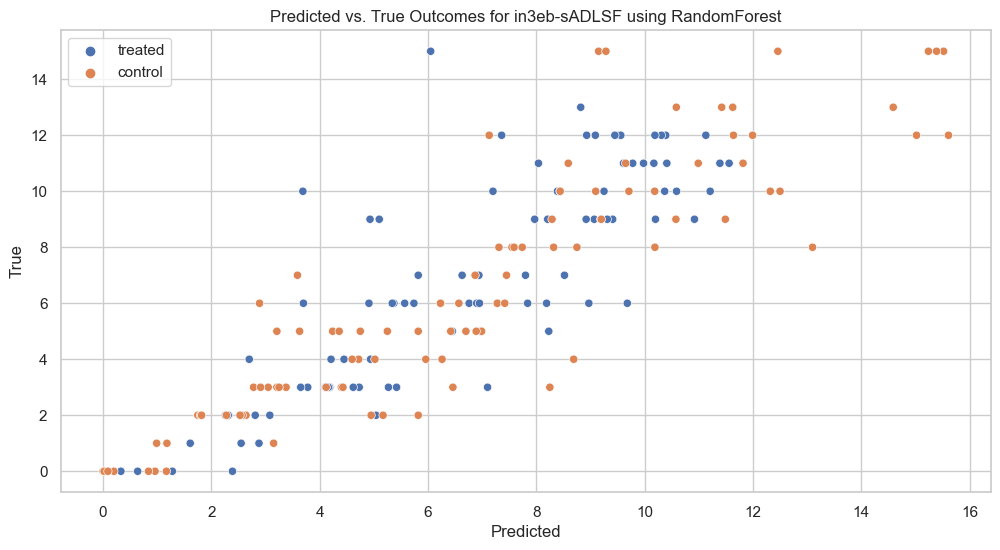

In [54]:
machine = "RandomForest"
visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Also, if we want to visualize the ITES, we can run the following function (``visualise_ites``):

ATE -0.34338325825825844


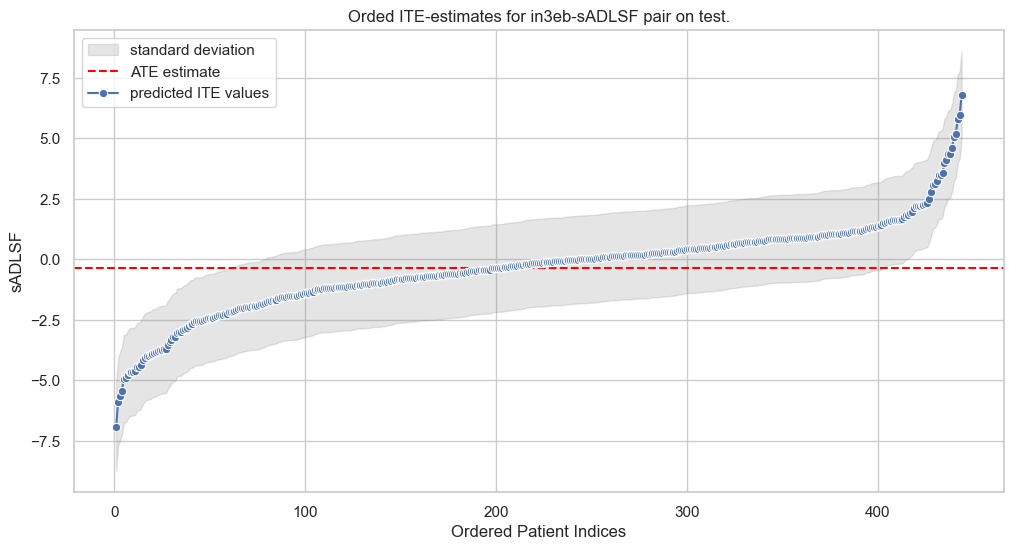

In [55]:
visualise_ites(ites_train, machine = machine, intervention = TREATMENT, target = OUTCOME)

### 3.b Run More Models

These models can be run also. Feel free to remove some of the models, but please run at least:

- ``RandomForestRegressor()``
- ``GradientBoostingRegressor()``
- ``LinearRegression()``

In [56]:
def visualise_ites1(ites, machine, target, intervention, split="test"): 
    ites = [i[0] for i in ites.reshape(-1,1)]
    ites = sorted(list(ites))

    x_values = range(1, len(ites) + 1)
    stdev = np.std(ites)
    upper_bound = [val + stdev for val in ites]
    lower_bound = [val - stdev for val in ites]

    sns.set(style="whitegrid")

    #plt.figure(figsize=(8,4))
    plt.figure(figsize=(12,6))

    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.2, label="standard deviation")
    plt.axhline(y=np.mean(ites), color='darkred', linestyle='--', label='ATE estimate')
    plt.xlabel("Ordered Patient Indices")
    plt.ylabel(f"Individual Treatment Effect")
    plt.title(f"Physical therapy, 45 minutes physical therapy per week")
    
    print(f"ATE {np.mean(ites)}")

    sns.lineplot(x=x_values, y=ites, marker='o', color='black', label='predicted ITE values', ci=stdev)
    plt.savefig(f"plots/{machine}-{intervention}-{target}.png", dpi=300)

    plt.show()
    

LinearRegression()
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
(Test) ATE -0.3334405952756878.
ATE: -0.15, 95% CI: [nan, nan]
ATE -0.33344059527568787


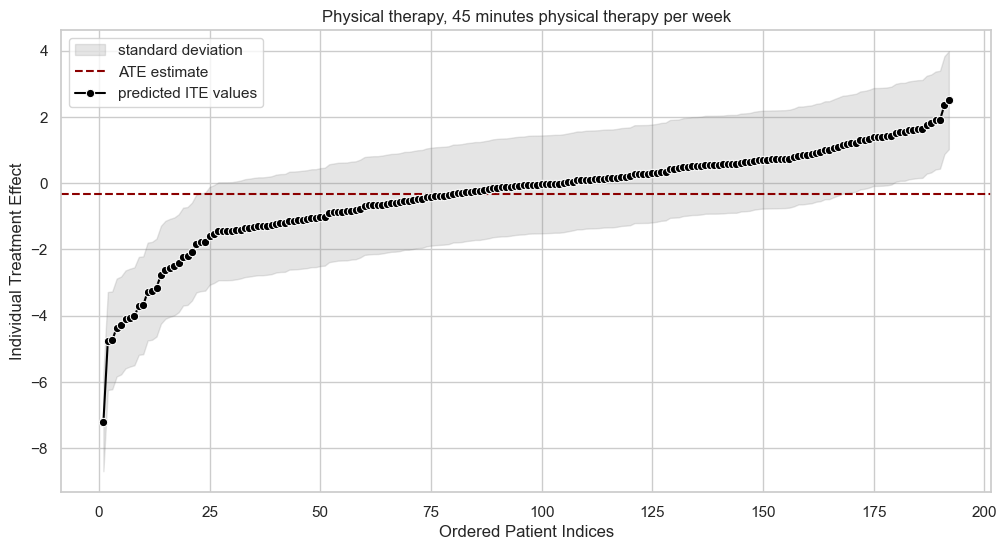

(-0.5444798610768332, -0.12240132947454241)
T-statistic: -3.1164764411444
P-value: 0.002112775237043749
Result is statistically significant
               LinearRegression()
MAE_C (test)             1.341953
MAE_T (test)             1.352936
MSE_C (test)             3.777568
MSE_T (test)             2.922939
R2_C (test)              0.796835
R2_T (test)              0.808064
MAE_C (train)            0.530405
MAE_T (train)            1.434232
MSE_C (train)            0.553395
MSE_T (train)            4.680545
R2_C (train)             0.970989
R2_T (train)             0.690369





In [57]:
model_lst = [
            (LinearRegression(), LinearRegression())]

for model1, model2 in model_lst:
    print(str(model1))
    np.random.seed(42)
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, X_train_c, X_train_t,y_train_t, y_train_c,X_combined_c,X_combined_t = run_model(n_bootstraps = 1, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1, zmienne=zmienne)
    #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
    visualise_ites1(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
    confidence_interval(data=ites_test)
    significance(data=ites_test)
    print(metrics)
    print("")
    print("")
    print("")

In [58]:
from sklearn.utils import resample
def get_confidence(X_train, y_train, model, n_bootstraps= 1000, alpha =0.05):
    coefs =np.zeros((n_bootstraps, X_train.shape[1]))
    for i in range(n_bootstraps):
        X_resmpled, y_resampled =resample(X_train, y_train)
        model.fit(X_resmpled, y_resampled)
        coefs[i,:] = model.coef_
    lower = np.percentile(coefs, 100*alpha/2, axis =0)
    
    upper = np.percentile(coefs, 100*(1-alpha/2), axis =0)
    return lower, upper

In [59]:
from sklearn.preprocessing import add_dummy_feature
def run_model_reg(n_bootstraps, file, model0, model1, machine, intervention, outcome, include_propensity, undersampled = False, num_iter = 1, zmienne =None):
    # if more iterations are necessary
    maec, maet, msec, mset, rtc, rtt = [], [], [], [], [], []
    tr_maec, tr_maet, tr_msec, tr_mset, tr_rtc, tr_rtt = [], [], [], [], [], []
    
    X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t, X_combined_c,X_combined_t= data_processing(file, undersampled,
                                                                                                         include_propensity, machine,
                                                                                                         intervention, outcome,
                                                                                                         target='OutcomeT1',
                                                                                                         treatment='treatment', caliper=0.2,
                                                                                                       zmienne =zmienne )
   
   
    
#     X_train_c =add_dummy_feature(X_train_c)
#     X_train_t =add_dummy_feature(X_train_t)
#     X_test_c =add_dummy_feature(X_test_c)
#     X_test_t =add_dummy_feature(X_test_t)
    
#     X_train_t.columns =['intercept'] +list(X_train_t.columns[1:])
#     X_train_c.columns =['intercept'] +list(X_train_c.columns[1:])
#     X_test_t.columns =['intercept'] +list(X_test_t.columns[1:])
#     X_test_c.columns =['intercept'] +list(X_test_c.columns[1:])
    f_c = model0
    f_c.fit(X_train_c, y_train_c)
    predictions_c = f_c.predict(X_test_c)
    # treated
    f_t = model1
    f_t.fit(X_train_t, y_train_t)

    predictions_t = f_t.predict(X_test_t)

    maec.append(mean_absolute_error(predictions_c, y_test_c))
    maet.append(mean_absolute_error(predictions_t, y_test_t))
    msec.append(mean_squared_error(predictions_c, y_test_c))
    mset.append(mean_squared_error(predictions_t, y_test_t))
    rtc.append(r2_score(y_test_c, predictions_c))
    rtt.append(r2_score(y_test_t, predictions_t))
    
    predictions_t_train = f_t.predict(X_train_t)
    predictions_c_train = f_c.predict(X_train_c)
    

    tr_maec.append(mean_absolute_error(predictions_c_train, y_train_c))
    tr_maet.append(mean_absolute_error(predictions_t_train, y_train_t))
    tr_msec.append(mean_squared_error(predictions_c_train, y_train_c))
    tr_mset.append(mean_squared_error(predictions_t_train, y_train_t))
    tr_rtc.append(r2_score(y_train_c, predictions_c_train))
    tr_rtt.append(r2_score(y_train_t, predictions_t_train))

    # compute ITEs for test
    ites_t_test = f_t.predict(X_test_t) - f_c.predict(X_test_t)
    ites_c_test = f_t.predict(X_test_c) - f_c.predict(X_test_c)
    # compute Individual treatment effects
    ites_test = np.append(ites_t_test, ites_c_test)

    # compute ITEs for train
    ites_t_train = f_t.predict(X_train_t) - f_c.predict(X_train_t)
    ites_c_train = f_t.predict(X_train_c) - f_c.predict(X_train_c)
    # compute Individual treatment effects
    ites_train = np.append(ites_t_train, ites_c_train)
    
    
    itest_treatment = np.append(ites_t_train,ites_t_test)
    
    # compute relevant errors and record 
    results = {'MAE_C (test)': np.mean(maec),
               'MAE_T (test)': np.mean(maet),
                'MSE_C (test)': np.mean(msec),
                'MSE_T (test)': np.mean(mset),
                 'R2_C (test)': np.mean(rtc),
                 'R2_T (test)': np.mean(rtt),
              'MAE_C (train)': np.mean(tr_maec),
               'MAE_T (train)': np.mean(tr_maet),
                'MSE_C (train)': np.mean(tr_msec),
                'MSE_T (train)': np.mean(tr_mset),
                 'R2_C (train)': np.mean(tr_rtc),
                 'R2_T (train)': np.mean(tr_rtt)}

    hyperparameters = f_t.get_params()
    print(hyperparameters)

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])
    df.to_csv(f'C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/hyperparameters/model_hyperparameters_{machine}.csv')

    metrics = pd.DataFrame.from_dict(results, orient = 'index', columns = [machine])
    metrics.to_csv(f"C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/results/model_results_{machine}_{intervention}-{outcome}.csv")
    
    filename_t = f"C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/storage/model_t_{machine}_{intervention}-{outcome}.sav"
    filename_c = f"C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/storage/model_c_{machine}_{intervention}-{outcome}.sav"

    # save models
    pickle.dump(f_t, open(filename_t, 'wb'))
    pickle.dump(f_c, open(filename_c, 'wb'))

    # Compute ITEs for test
    ites_t = f_t.predict(X_test_t) - f_c.predict(X_test_t)
    ites_c = f_t.predict(X_test_c) - f_c.predict(X_test_c)
    
    outcome_under_treatment = np.concatenate([f_t.predict(X_test_t), f_t.predict(X_test_c)])
    outcome_under_treatment = np.mean(outcome_under_treatment)
    
    outcome_under_control = np.concatenate([f_c.predict(X_test_t), f_c.predict(X_test_c)])
    outcome_under_control = np.mean(outcome_under_control)
    
    print(f"(Test) ATE {outcome_under_treatment - outcome_under_control}.")
    
    

    # Compute individual treatment effects
    ites_test = np.concatenate([ites_t, ites_c])
    
#     ate_confidence(model0, model1, machine, X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t, n_bootstraps = n_bootstraps)
    
        
    return metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train,itest_treatment, X_test_t, X_test_c, X_train_c, X_train_t, y_train_c, y_train_t


In [60]:

model = [(LinearRegression(), LinearRegression())]

for model0, model1 in model:
    np.random.seed(42)
    print(str(model0))
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train,itest_treatment, X_test_t, X_test_c, X_train_c, X_train_t, y_train_t, y_train_c = run_model_reg(n_bootstraps = 1, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1, zmienne=zmienne)
    np.random.seed(42)
    coefficients_c = pd.DataFrame({
        'Feature': X_test_c.columns,
        'Coefficient': model0.coef_ })
    
    coefficients_t = pd.DataFrame({
        'Feature': X_test_t.columns,
        'Coefficient': model1.coef_
    })

#     lower, upper = get_confidence(X_train_c, y_train_c, model0)
#     coefficients_c['CI_Lower']=lower
#     coefficients_c['CI_Upper']=upper
    
#     lower, upper = get_confidence(X_train_t, y_train_t, model1)
#     coefficients_t['CI_Lower']=lower
#     coefficients_t['CI_Upper']=upper
    



LinearRegression()
LinearRegression()
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
(Test) ATE -0.22853411260508238.


In [61]:
def ite_classification_for_test_training_treatment(x):
    if  -0.05 <= x <= 0.05:
        return "the same"
    elif x < -0.05:
        return "benefit"
    elif x > 0.05:
        return "worsening"
    

In [62]:
X_TEST_T = X_test_t
X_TEST_C = X_test_c
X_TRAIN_T = X_train_t
X_TRAIN_C = X_train_c



X_TEST_T['predictions'] = predictions_t
X_TEST_C['predictions'] = predictions_c

X_TEST_TRAIN = pd.concat([ X_TRAIN_T,X_TEST_T])
# y_test = pd.concat([y_test_t, y_test_c])
# X_TEST['OutcomeT1'] =y_test
X_TEST_TRAIN['ITES'] =itest_treatment

In [63]:
X_TEST_TRAIN['benefit']= X_TEST_TRAIN['ITES'].apply(ite_classification_for_test_training_treatment)

In [64]:
# for x in X_TEST_TRAIN.columns:
#     print(pd.crosstab(X_TEST_TRAIN[x], X_TEST_TRAIN['benefit'], normalize ='index')*100)


In [65]:
# for x in X_TEST_TRAIN.columns:
#     print(pd.crosstab(X_TEST_TRAIN[x], X_TEST_TRAIN['benefit']))

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.robust import RLM



def run_model1(n_bootstraps, file, model0, model1, machine, intervention, outcome, include_propensity, undersampled = False, num_iter = 1, zmienne =None):
    # if more iterations are necessary
    maec, maet, msec, mset, rtc, rtt = [], [], [], [], [], []
    tr_maec, tr_maet, tr_msec, tr_mset, tr_rtc, tr_rtt = [], [], [], [], [], []
    
    X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t,X_combined_c,X_combined_t= data_processing(file, undersampled,
                                                                                                         include_propensity, machine,
                                                                                                         intervention, outcome,
                                                                                                         target='OutcomeT1',
                                                                                                         treatment='treatment', caliper=0.2,
                                                                                                       zmienne =zmienne )
    

    np.random.seed(42)
    X_c = sm.add_constant(X_train_c)   
    X_t = sm.add_constant(X_train_t)
    model0 =sm.OLS(y_train_c, X_c)
    model1 =sm.OLS(y_train_t, X_t)
#     model0 =sm.OLS(y_train_c, X_train_c)
#     model1 =sm.OLS(y_train_t, X_train_t)
    result0 =model0.fit()
    result1 = model1.fit()  
#     y_pred_c =result0.predict( sm.add_constant(X_train_c))
#     print(y_pred_c)
    
#     y_pred_t =result1.predict(sm.add_constant(X_train_t))
#     print(y_pred_t)
#     print(result0.summary())
#     print(result1.summary())
    
    

                       
    
    vif_c =pd.DataFrame()
    vif_c['Variable_c'] = X_c.columns
    vif_t =pd.DataFrame()

    vif_t['Variable_t'] = X_t.columns
    vif_c['VIF_c'] = [variance_inflation_factor(X_c, i) for i in range(X_c.shape[1])]
#     print(vif_c)
    vif_t['VIF_t'] = [variance_inflation_factor(X_t, i) for i in range(X_t.shape[1])]
#     print(vif_t)
    
    vif_c['Tolerance'] =1/vif_c['VIF_c']
#     print(f"TOLERANCE Control:")
#     print(vif_c)
    vif_t['Tolerance'] =1/vif_t['VIF_t']
#     print(f"TOLERANCE Treatment:")
#     print(vif_t)


    return y_test_t, y_test_c, X_test_t, X_test_c, X_train_c, X_train_t, y_train_c, y_train_t,X_combined_c,X_combined_t



In [67]:
import statsmodels.api as sm

#
np.random.seed(42)
#     print(str(model0))
#     print(str(model1))
y_test_t, y_test_c, X_test_t, X_test_c, X_train_c, X_train_t, y_train_t, y_train_c,X_combined_c,X_combined_t = run_model1(n_bootstraps = 1, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1, zmienne=zmienne)

    
      

RandomForestRegressor()
RandomForestRegressor()
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
(Test) ATE -0.4741475694444439.
ATE: -0.31, 95% CI: [nan, nan]
ATE -0.4741475694444444


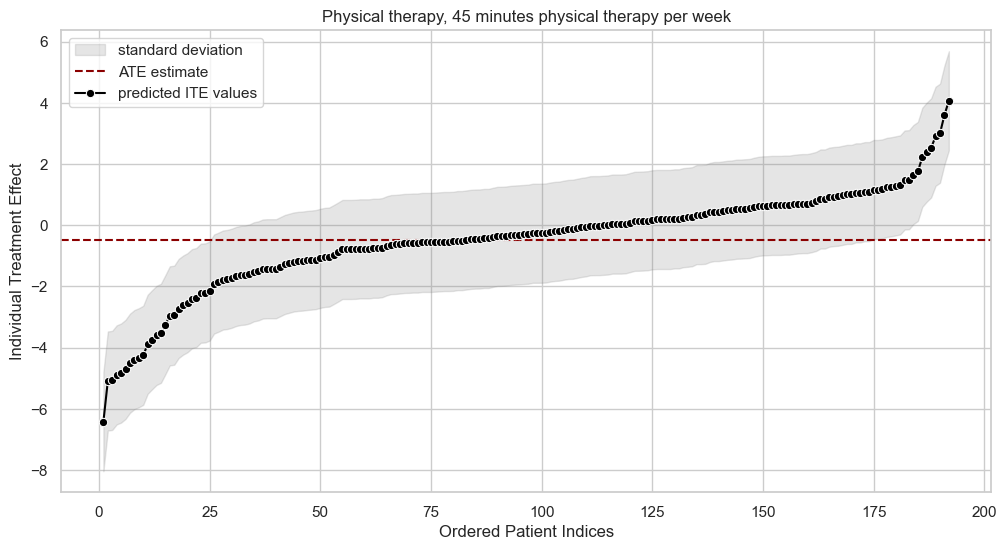

(-0.7053323328751608, -0.24296280601372802)
T-statistic: -4.045413912187095
P-value: 7.576533785249482e-05
Result is statistically significant


In [68]:
model = [(RandomForestRegressor(), RandomForestRegressor())]

import shap


for model0, model1 in model:
    np.random.seed(42)
    print(str(model0))
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, X_train_c, X_train_t ,y_train_t, y_train_c,X_combined_c,X_combined_t= run_model(n_bootstraps = 1, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1, zmienne=zmienne)
    
#     feature_rename_map={
#     "ig2h_2": "Toilet use_severe",
#     "ig2f_2": "Locomotion_severe",
#     "ig2b_2": "Personal hygiene_severe",
#     "ih1": "Bladder continence",
#     "ig2h_1": "Toilet use_moderate",
#     "ig2j_1": "Eating_moderate",
#     "ig2f_1": "Locomotion_moderate",      
#     "ig2b_1": "Personal hygiene_moderate",
#     "ij2a": "Difficulty standing",
        
#     "ij2b": "Difficulty turning around",
#     "sCPS_2": "CPS_moderate",
#     "sAGE_cat_2.0": "Age_80_89",
#     "sCPS_1": "CPS_mild",
#     "sCPS_3": "CPS_severe",
#     "ig2j_2": "Eating_severe",
#     "sAGE_cat_3.0": "Age_90_more",
        
#     "ij2d": "Unsteady gait",
#     "ij2c": "Dizziness",
        
#     "ih3": "Bowel continence",
#     "il7": "Foot problems",
#     "iA2": "Sex" ,
#     "ii1h": "Parkinson's disease",
#     "ii1e": "Hemiplegia",
#     "sADLH_2.0": "ADL_severe",
#     "sADLH_1.0": "ADL_moderate"


#     }

#     X_combined_c =X_combined_c.rename(columns=feature_rename_map)
#     X_combined_t =X_combined_t.rename(columns=feature_rename_map)


#     print("CONTROL")
    
#     explainer = shap.TreeExplainer(model0)
#     shap_values_c =explainer.shap_values(X_combined_c)
#     shap.summary_plot(shap_values_c, X_combined_c, max_display =30)
# #     print("TREATMENT")

#     explainer_t =shap.TreeExplainer(model1)
#     shap_values_t =explainer_t.shap_values(X_combined_t)
#     shap.summary_plot(shap_values_t, X_combined_t,  max_display =30)
    

    visualise_ites1(ites_test, machine =str(model1), intervention =TREATMENT, target =OUTCOME)
    confidence_interval(data=ites_test)
    significance(data=ites_test)
#     print(metrics)

In [69]:
X_TEST_T = X_test_t
X_TEST_C = X_test_c
X_TEST_T['predictions'] = predictions_t
X_TEST_C['predictions'] = predictions_c
X_TEST = pd.concat([X_TEST_T, X_TEST_C])
y_test = pd.concat([y_test_t, y_test_c])
X_TEST['OutcomeT1'] =y_test
X_TEST['ITES'] =ites_test

In [70]:
def ite_classification(x):
    if  -0.05 <= x <= 0.05:
        return "the same"
    elif x < -0.05:
        return "worsening"
    elif x > 0.05:
        return "benefit"
    

In [71]:
X_TEST['benefit']= X_TEST['ITES'].apply(ite_classification)

In [72]:
X_TEST.to_csv(f"Z:/Paulina Wiśniewska/data_frame_po_modelach.csv")

In [73]:
df = pd.read_csv(f"Z:/Paulina Wiśniewska/data_frame_po_modelach.csv")

In [74]:
X_TEST =df

In [75]:
def zmiana_class(x):
    if 0 <= x < 0.5:
        return 0
    elif 0.5 <= x < 1.5:
        return 1
    elif 1.5 <= x< 2.5:
        return 2
    elif 2.5 <= x < 3.5:
        return 3
    elif 3.5 <= x < 4.5:
        return 4
    elif 4.5 <= x< 5.5:
        return 5
    elif 5.5 <= x< 6.5:
        return 6
    elif 6.5 <= x<7.5:
        return 7
    elif 7.5 <= x< 8.5:
        return 8
    elif 8.5 <=x< 9.5:
        return 9
    elif 9.5 <= x< 10.5:
        return 10
    elif 10.5 <= x< 11.5:
        return 11
    elif 11.5 <= x< 12.5:
        return 12
    elif 12.5 <= x< 13.5:
        return 13
    elif 13.5 <= x< 14.5:
        return 14
    elif 14.5 <= x< 15.5: 
        return 15
    elif 15.5 <= x< 16.5:
        return 16
    
X_TEST['predictions'] = X_TEST['predictions'].apply(zmiana_class)

In [76]:
cross_tab = pd.crosstab(pd.Series(X_TEST['OutcomeT1']), pd.Series(X_TEST['predictions']))

In [77]:
cross_tab = pd.crosstab(pd.Series(X_TEST['OutcomeT1']), pd.Series(X_TEST['predictions']))

In [78]:
metrics

,RandomForestRegressor()
MAE_C (test),1.341953
MAE_T (test),1.519479
MSE_C (test),3.777568
MSE_T (test),4.260657
R2_C (test),0.796835
R2_T (test),0.720222
MAE_C (train),0.530405
MAE_T (train),0.700315
MSE_C (train),0.553395
MSE_T (train),1.085026


## 3.c IDs for Evaluation

## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

In [79]:
device = torch.device("cpu")

It is useful to have a small function that easily converts arrays to the correct ``torch``-objects: tensors.

In [80]:
to_tensor = lambda x: torch.tensor(np.array(x), dtype = torch.float32).to(device)

In [81]:
FILE = f"Z:/Paulina Wiśniewska/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"
df = pd.read_csv(FILE)

### Uplift Model

In [82]:
# # Split into features and target
# X = df.drop('OutcomeT1', axis=1)
# y = df['OutcomeT1']

# # Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Train model on treatment group
# model_treatment = LogisticRegression()
# model_treatment.fit(X_train[X_train['treatment'] == 1].drop('treatment', axis=1), y_train[X_train['treatment'] == 1])

# # Train model on control group
# model_control = LogisticRegression()
# model_control.fit(X_train[X_train['treatment'] == 0].drop('treatment', axis=1), y_train[X_train['treatment'] == 0])

# # Predict probabilities
# prob_treatment = model_treatment.predict_proba(X_test.drop('treatment', axis=1))[:, 1]
# prob_control = model_control.predict_proba(X_test.drop('treatment', axis=1))[:, 1]

# # Calculate uplift
# uplift = prob_treatment - prob_control

# # Sorting the individuals by predicted uplift
# order = np.argsort(uplift)[::-1]
# sorted_uplift = uplift[order]

# # Calculating cumulative uplift
# cumulative_uplift = np.cumsum(sorted_uplift) / len(y_test)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.xlim(0,100)
# plt.plot(cumulative_uplift, label='Uplift Curve')
# plt.xlabel('Proportion Targeted')
# plt.ylabel('Cumulative Uplift')
# plt.title('Uplift Curve')
# plt.legend()
# plt.show()

In [83]:
# apply min-max normalisation
#X = df.drop(columns = ['treatment', 'OutcomeT1']).columns
#df[X] = (df[X] - df[X].min()) / (df[X].max() - df[X].min())

In [84]:
X = df.drop(columns = ['treatment', 'OutcomeT1']).columns

normalizer = Normalizer(norm="l2")
normalizer.fit(df[X])

df[X] = normalizer.fit_transform(df[X])

with open(f'C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/storage/normalizer_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

### 4 a. Perform Undersampling Procedure

In [85]:
if UNDERSAMPLE:
    freq_treated = len(df[df['treatment']==1])
    control = df[df['treatment']==0].sample(freq_treated)
    treated = df[df['treatment']==1]
    df = pd.concat((control, treated))
    
# print(f'DF lenght after undersampling: {len(df)}')

Because the model is a neural-network based architecture, it is usually helpful to apply min-max normalisation which converts the column values to \[0,1\] ranges.

### 4.b Train-Test Splitting

In the cell below, we perform train-test split. Note that we also split the train and test data into two groups: a control group and a treated group. Even though we do not explicItely use for train, it will be useful for the (sub-)group evaluation later on.

In [86]:
# variable setting for treatment
t = 'treatment'
# select the relevant outcome
y = "OutcomeT1" 
# specify test size
test_size = 0.2

# Split groups into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = [y]), df[['treatment', y]], test_size=test_size, random_state=42)

### 4.c Propensity Score Computation

In [87]:
# predict the propensity score
if PROPENSITY:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]
    X_test["OutcomeT1"] = y_test["OutcomeT1"]
    X = X_train.drop(columns = ['treatment']).columns
    X = X_test.drop(columns = ['treatment']).columns
    ps_model = LogisticRegression(C=1e2, max_iter=10000).fit(X_train[X], y_train['treatment'])
    X_train['ps'] = ps_model.predict_proba(X_train[X])[:, 1]
    X_test['ps'] = ps_model.predict_proba(X_test[X])[:, 1]
    
    # ensure that treatment is last column
    X_train['treatment_new'] =  X_train['treatment']
    X_train = X_train.drop(columns = ['treatment'])
    X_train = X_train.rename(columns = {'treatment_new': 'treatment'})
    
    X_test['treatment_new'] =  X_test['treatment']
    X_test = X_test.drop(columns = ['treatment'])
    X_test = X_test.rename(columns = {'treatment_new': 'treatment'})
    
    #X_train = X_train.drop(columns = ["OutcomeT1"])
else:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]

In [88]:
X = df.drop(columns = ['OutcomeT1', 'treatment']).columns

#X_train = X_train.drop(columns = ["ps"])

# Estimate the average treatment effect (group level)
tau_est = doubly_robust(X_train, X=X, T='treatment', Y='OutcomeT1')
tau_est = torch.tensor(tau_est, dtype = torch.float32).to(device)
# print(tau_est)

# drop columns
X_train = X_train.drop(columns = ["OutcomeT1"])

if PROPENSITY == True:
    X_test = X_test.drop(columns = ["OutcomeT1"])

Estimated outcome under control 5.431093345021811.
Estimated outcome under treatment 5.299734009365961.


We also want to make sure that the data stuctures are in the right format. For this, we use ``to_tensor``.

In [89]:
y_t = y_train[y_train['treatment']==1][y]
y_c = y_train[y_train['treatment']==0][y]

y_test_t = y_test[y_test['treatment']==1][y]
y_test_c = y_test[y_test['treatment']==0][y]

In [90]:
# convert output to tensors
x, y, y_t, y_c, x_test = to_tensor(X_train), to_tensor(y_train), to_tensor(y_t), to_tensor(y_c), to_tensor(X_test)

### 4.d Model Training

The next step is to train the actual model. The code below sets some preliminary configurations.

In [91]:
# Configurations
lr = 0.001
epochs = 1000
gamma = 2

model = TARnetICFR(x.shape[1], 0.01, hidden_dim = 32*4).to(device)

# Define the loss functions
head_loss = nn.L1Loss() #nn.MSELoss()#nn.L1Loss() #torch.nn.HuberLoss(reduction = 'mean', delta = 1) #nn.MSELoss() # nn.L1Loss() #nn.MSELoss() 

# initialise optimiser
optimizer = optim.Adam(model.parameters(), lr)

u = len(y_t)  / (len(y_t)  + len(y_c))

The code below is the training loop. On each loop, the model passes the data through the models, examines its performance and adjust the weights. Note that this model has four loss components:

1. Component 1 (``loss1``) is to loss on the treated segment of the data.
2. Component 2 (``loss2``) is to loss on the control segment of the data.
3. Component 2 (``loss_cf_3``) is to loss on the counterfactual control segment of the data.
4. Component 2 (``loss_cf_4``) is to loss on the counterfactual treated segment of the data.

In [92]:
# Define loss lists
loss1_lst, loss2_lst, loss3_lst = [], [], []

for epoch in range(epochs):
    # Forward pass
    output_t, output_c, _ = model(x)
    
    # Compute total loss and update the model's parameters
    loss1, loss2 = head_loss(torch.squeeze(output_t), y_t), head_loss(torch.squeeze(output_c), y_c)
    
    pred_c_cf = model.forward_treated(x[x[:,-1]==0])
    loss_cf_3 = (1 - u) * torch.mean((torch.squeeze(pred_c_cf) - (y_c + tau_est))**2)
                 
    pred_t_cf = model.forward_control(x[x[:,-1]==1])
    loss_cf_4 = u * torch.mean((torch.squeeze(pred_t_cf) - (y_t - tau_est))**2)
    
    # losses added
    loss = loss1 + (loss2) + loss_cf_3 + loss_cf_4 #+ (gamma * loss3)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10000 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}')
        
        # print intermediate results on test
        x_test_t = x_test[x_test[:,-1]==1] 
        x_test_c = x_test[x_test[:,-1]==0] 

        # # examine intermediate factual test performance
        y_t_pred = model.forward_treated(x_test_t).cpu().detach().numpy().reshape(len(x_test_t),)
        y_c_pred = model.forward_control(x_test_c).cpu().detach().numpy().reshape(len(x_test_c),)

        print(f"RMSE for factual treated {mean_squared_error(y_t_pred, y_test_t)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_t_pred, y_test_t)}") 
        print(f"RMSE for factual control {mean_squared_error(y_c_pred, y_test_c)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_c_pred, y_test_c)}") 

Epoch 100/1000 | Loss: 6.7562
RMSE for factual treated 7.821965426270467
MAE for factual treated 1.903556759590688
RMSE for factual control 4.719657235750399
MAE for factual treated 1.1669835726320743
Epoch 200/1000 | Loss: 5.5597
RMSE for factual treated 6.841574997614931
MAE for factual treated 1.5955221277216207
RMSE for factual control 4.782761377712657
MAE for factual treated 1.0610059261322022
Epoch 300/1000 | Loss: 5.1535
RMSE for factual treated 6.899437472447091
MAE for factual treated 1.5568107435668723
RMSE for factual control 5.034674101484303
MAE for factual treated 1.070976370856166
Epoch 400/1000 | Loss: 4.8398
RMSE for factual treated 5.930697946375477
MAE for factual treated 1.3888005739536837
RMSE for factual control 4.808255100616001
MAE for factual treated 1.0505122268497944
Epoch 500/1000 | Loss: 4.7340
RMSE for factual treated 6.558220971185862
MAE for factual treated 1.6238749094199443
RMSE for factual control 4.4367799693812255
MAE for factual treated 0.98308635

### 4.e Model Evaluation
Having trained the model, we can no examine the performance on the test set. We first get the predictions for the treated and control groups. Then we visualise the predicted predicted vs. true values. 

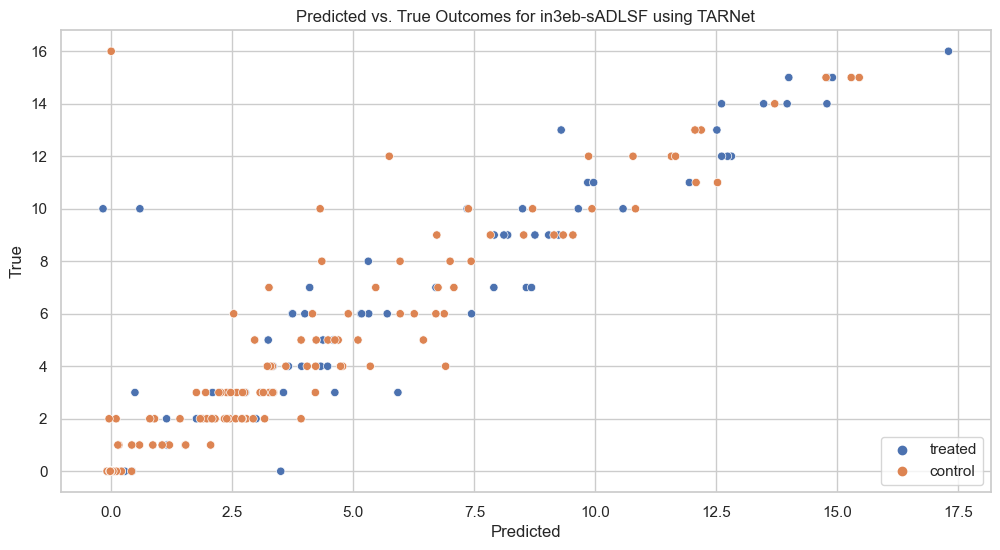

In [93]:
y_t_pred = model.forward_treated(x_test[x_test[:,-1]==1] ).cpu().detach().numpy()
y_c_pred = model.forward_control(x_test[x_test[:,-1]==0] ).cpu().detach().numpy()

machine = "TARNet"
visualise(np.squeeze(y_t_pred), np.squeeze(y_c_pred), y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Next, we want to estimate the model's predictions of the individual treatment effect. We plot this in an ordered fashion (from most beneficial to least beneficial). The blue dots depict patients. On the y-axis, we find the effect size as predicted by the model. 

ATE_est = 5.007778644561768 - 4.959611892700195 = 0.04816688969731331.
ATE 0.04816684499382973


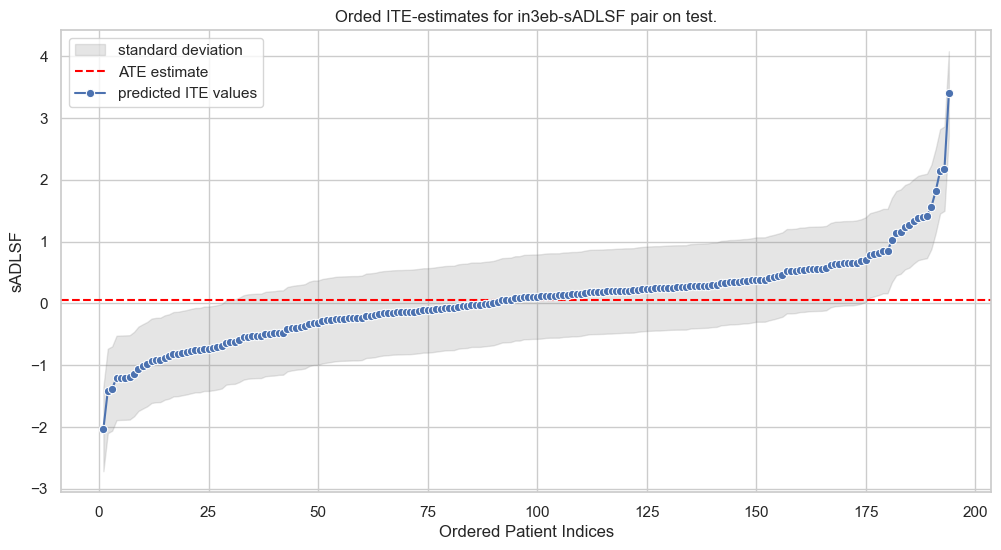

In [94]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()
y_t_predt1 = model.forward_treated(x_test_t).cpu().detach().numpy()
y_t_pred = np.concatenate((y_c_predt1, y_t_predt1))

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() #np.array(y_test_c).reshape(-1,1) #model.forward_control(x_test_c).cpu().detach().numpy()
y_t_predt0 = model.forward_control(x_test_t).cpu().detach().numpy()

y_c_pred = np.concatenate((y_c_predt0, y_t_predt0))

# compute the ites and sort
ites = y_t_pred - y_c_pred
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_t_pred - y_c_pred)

print(f"ATE_est = {np.mean(y_t_pred)} - {np.mean(y_c_pred)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE_est = 4.135763168334961 - 4.1499786376953125 = -0.014215302653610706.
ATE -0.01421530731022358


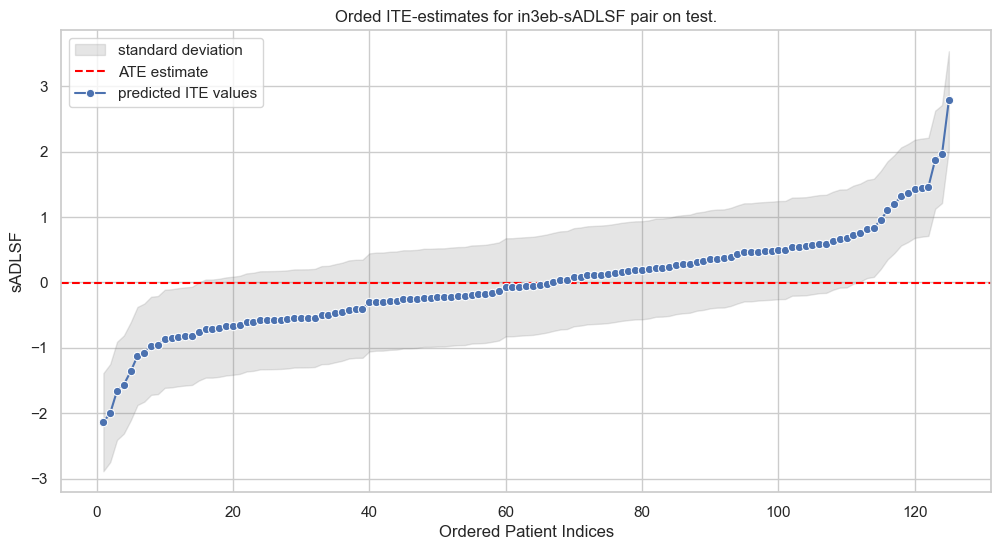

In [95]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() 

# compute the ites and sort
ites = y_c_predt1 - y_c_predt0
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_c_predt1 - y_c_predt0)

print(f"ATE_est = {np.mean(y_c_predt1)} - {np.mean(y_c_predt0)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

### 4.e Variable Importances

In [96]:
np.random.seed(42)

# Calculate the baseline performance
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Ensure no gradients are computed
    output_t, output_c, _ = model(x)
baseline_performance = mean_squared_error(output_t, y_t)
print(baseline_performance)

# Initialize a list to hold the feature importances
feature_importances = []
icodes = []
meanings = []
rank = []

collist = X_train.columns

# Calculate the importance for each feature
for i in range(x.shape[1]):  # Iterate over each feature
    # Save the original feature
    original_feature = x[:, i].clone()
    # Permute the feature
    permuted_feature = original_feature[torch.randperm(original_feature.size(0))]
    x[:, i] = permuted_feature
    
    # Calculate performance with the permuted data
    with torch.no_grad():
        output_t, output_c, _ = model(x)
        
    permuted_performance_t = mean_squared_error(output_t, y_t)
    permuted_performance_c = mean_squared_error(output_c, y_c)
    
    permuted_performance = permuted_performance_t + permuted_performance_t
    
    # Calculate the importance as the change in performance
    importance = baseline_performance - permuted_performance
    feature_importances.append(importance)
    
    # Restore the original feature
    x[:, i] = original_feature
    
# Rank the features by their importance
sorted_features = np.argsort(feature_importances)[::-1]  # Indices of features, sorted by importance

# Print the feature importances
# print("Feature importances:")
# for i, feature_index in enumerate(sorted_features):
#     #print(f"Feature {feature_index}: Importance {feature_importances[feature_index]}")
#     icode = collist[feature_index]
#     icodes.append(icode.lower())
    
#     try:
#         item = encoding[icode.lower()]
#         #print(item)
#         meanings.append(item)
#     except KeyError:
#         #print(f'{icode} not found')
#         meanings.append(f'{icode} not found')
#     #print("==================================================")
    
# rankings = pd.DataFrame(icodes, columns = ['icodes'])
# rankings['meanings'] = meanings
# rankings['importance_values'] = feature_importances

# rankings = rankings.sort_values(by = 'importance_values')
# rankings = rankings.reset_index().drop(columns = 'index')
# rankings

1.1524757


## Save Model

In [97]:
model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,

In [98]:
model = model
location = 'storage'

In [99]:
# save model
with open(f'C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/storage/model_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [100]:
# load model
with open(f'C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/storage/model_{TREATMENT}-{OUTCOME}.pkl', 'rb') as b:
    loaded_model = pickle.load(b)

In [101]:
loaded_model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,